In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [2]:
# 1. 데이터 전처리
def create_classification_targets(data, window_size=10, pred_offset=1):
    X = []
    y = []
    for i in range(len(data) - window_size - pred_offset + 1):
        # 10분 동안의 Close와 Volume 데이터
        X.append(data.iloc[i:i+window_size][['Close', 'Power']].values)
        # 3분 뒤의 Close 가격 변화에 따른 클래스 설정
        future_close = data.iloc[i+window_size+pred_offset-1]['Close']
        current_close = data.iloc[i+window_size-1]['Close']
        
        # 가격 변화에 따라 클래스 설정: 상승(2), 보합(1), 하락(0)
        if future_close > current_close:
            y.append(2)  # 상승
        elif future_close < current_close:
            y.append(0)  # 하락
        else:
            y.append(1)  # 보합
    return np.array(X), np.array(y)

# 데이터 불러오기 및 전처리
data = pd.read_csv('./000660.csv', parse_dates=['Unnamed: 0'])
data = data.rename(columns={'Unnamed: 0': 'Time', '매수량': 'BuyVolume', '매도량': 'SellVolume', '종가': 'Close'})
data['Power'] = data['BuyVolume'] - data['SellVolume']
data = data[['Time', 'Close', 'Power']].dropna()

X, y = create_classification_targets(data)

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(sample) for sample in X])

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train.shape)  # (samples, 10, 2)
print(y_train.shape)  # (samples,)

(149464, 10, 2)
(149464,)


In [3]:
print("X_train shape:", X_train.shape)  # (num_samples, 10, 2)
print("y_train shape:", y_train.shape)  # (num_samples,)

X_train shape: (149464, 10, 2)
y_train shape: (149464,)


In [4]:
# 2. Positional Encoding 구현
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # 짝수 인덱스에 대해 sin 적용
    sines = np.sin(angle_rads[:, 0::2])

    # 홀수 인덱스에 대해 cos 적용
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return pos_encoding

def add_positional_encoding(inputs, max_len, d_model):
    pos_encoding = positional_encoding(max_len, d_model)
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    
    pos_encoded_inputs = layers.Lambda(
        lambda x: x + pos_encoding[:tf.shape(x)[1], :]
    )(inputs)
    return pos_encoded_inputs

# 3. Transformer 블록 구현
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output1 = self.att1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1)
        out1 = self.layernorm1(inputs + attn_output1)
        # attn_output2 = self.att2(out1, out1)
        # attn_output2 = self.dropout2(attn_output2)
        # out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout1(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# 4. Transformer 모델 구성
def create_transformer_model(input_shape, num_heads, ff_dim, d_model, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # 임베딩 및 위치 인코딩
    embedding_layer = layers.Dense(d_model)(inputs)
    pos_encoded_inputs = add_positional_encoding(embedding_layer, max_len=input_shape[0], d_model=d_model)

    # Transformer 블록 적용
    transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
    x = transformer_block(pos_encoded_inputs)
    
    # 출력 레이어
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="gelu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# 5. 모델 생성 및 학습
input_shape = (10, 2)  # 10분 동안의 데이터 (2개의 피처: Close, Volume)
model = create_transformer_model(input_shape, num_heads=2, ff_dim=64, d_model=16, num_classes=3)

# 모델 컴파일
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 얼리스탑 콜백
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    restore_best_weights=True
)

# 모델 학습
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2)]           0         
                                                                 
 dense (Dense)               (None, 10, 16)            48        
                                                                 
 lambda (Lambda)             (None, 10, 16)            0         
                                                                 
 transformer_block (Transfor  (None, 10, 16)           4352      
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 128)               2176  

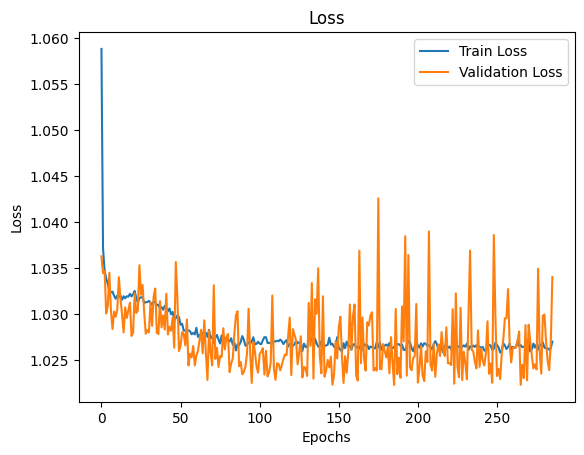

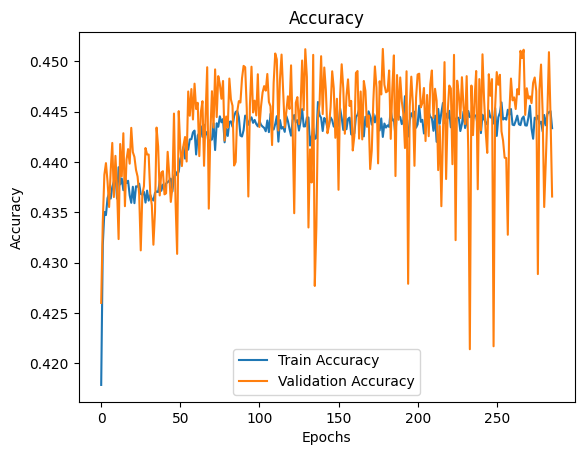

In [5]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
